# Primera exploración en Machine Learning

Vamos a construir una forma simple de sistema de reconocimiento de objetos. Para ello utilizaremos un dataser de ejemplo para entrenar nuestro programa que consiste de diferentes tipos de frutas. Cada fruta cuenta con ciertas caracteristicas como peso, color, dimensiones, texturas, etc, que servirán de input en nuestro programa.
Podemos pensar en el input como una tabla de datos, donde cada objeto (la fruta) es representada por una fila y los atributos del objeto (tamaño, color, textura) son representados por los valores a traves de las columnas.

In [36]:
#Librerias que debemos importar
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [37]:
#Cargamos el dataset que usaremos para entrenar nuestro programa
fruits = pd.read_table('fruit_data_with_colors.txt')

In [38]:
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [39]:
#Podemos ver las dimensiones del DF. 59 filas y 7 columnas
fruits.shape

(59, 7)

In [40]:
#¿cuantas frutas tenemos? tenemos 4 tipos de fruta
fruits['fruit_name'].unique()
#Escribiremos un diccionario que relacione el nombre de la fruta con la etiqueta
lookup_fruit_name = dict(zip(fruits.fruit_label.unique(), fruits.fruit_name.unique()))   
lookup_fruit_name

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

Nuestro objetivo es construir in clasificador para este conjunto de datos que sea capaz de predecir el tipo de fruta correcto para algún input que le demos.

Un punto importante que debemos tener en cuenta. SUpongamos que ya contamos con nuestro calsificador listo. ¿Como nos aseguramos que las predicciones que haga estan bien hechas?. Una alternativa sería tomar algunos datos de la muestra que usamos para entrenar el programa y compararla con la predicción hecha. Sin embargo, este prodecimiento no es del todo correcto, ya que estaríamos verificando la eficiencia del programa con datos ya utilizados para entrenarlo haciendo que la verificación no fuera válida. Queremos que nuestro programa sea capaz de predecir de manera correcta cualquier input que le pongamos en el futuro y que sea distinto del input de entrenamiento. Por lo tanto, si queremos testear la eficiencia del programa lo que debemos hacer es separar el dataset de entrenamiento en 2 partes, una para entrenar el programa (training set) y otra para verificar que la predicción está bien hecha (test set). Para hacer esto usaremos una función de scikit-learn llamada train_test_split.

### Create a train-test split
Usamos train_test_split. El flag teat_size: indica que % de los datos se va a train y que % se va a test. Por defecto test_size=None que significa 25% para test. random_state proporciona la semilla para la funcion interna de numeros aleatoreos. 

In [41]:
X = fruits[['height', 'width', 'mass', 'color_score']] #caracteristicas de la fruta
y = fruits['fruit_label'] #nombre de la fruta
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

In [42]:
print('{:.2f}% de los datos X son para entrenar y {:.2f}% de X son para test'.format(len(X_train)/len(X), len(X_test)/len(X)))
print('{:.2f}% de los datos y son para entrenar y {:.2f}% de y son para test'.format(len(y_train)/len(y), len(y_test)/len(y)))

0.75% de los datos X son para entrenar y 0.25% de X son para test
0.75% de los datos y son para entrenar y 0.25% de y son para test


### Examinando los datos

Antes de ponerse a trabajar con Machine Learning siempre es bueno merar los datos. Ya sea con algun gráfico, tabla resumen o simplemente a mano mirando cada fila. La razones para hacer esto son variadas:

a) Te da una visión de qué es lo que hay en el data set

b) Puedes notar si hay datos faltantes, inconsistencia en los datos,      tipos de variables mal usada, mal uso de las unidades, etc.

c) Quizás te des cuenta que tu problema se puede resolver sin usar        machine learning.

Hagamos un grafico para ver si nuestros datos presentan algun dato extraño que contribuya a generar ruido más adelante o si existe algun tipo de patron que nos ayude a escoger mejor el tipo de clasificador que vamos a usar. Para graficar los datos usaremos un scatter matrix

<IPython.core.display.Javascript object>


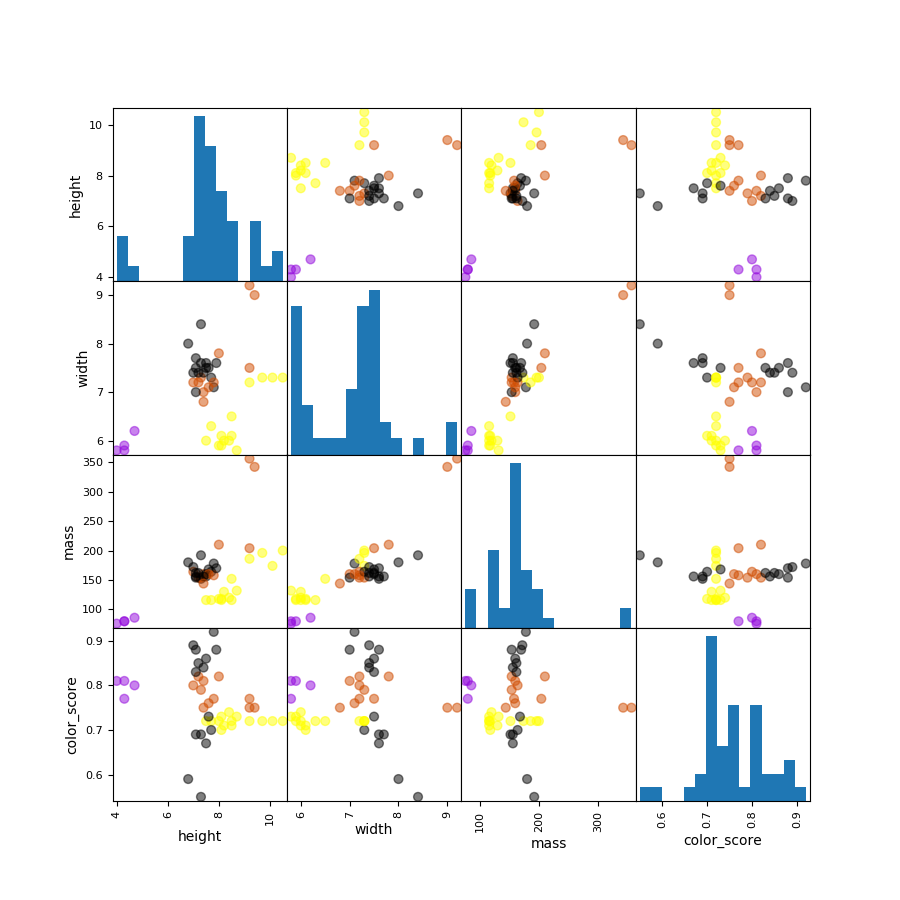

In [43]:
from matplotlib import cm
cmap = cm.get_cmap('gnuplot')
scatter = pd.scatter_matrix(X_train, c= y_train, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap=cmap)

<IPython.core.display.Javascript object>


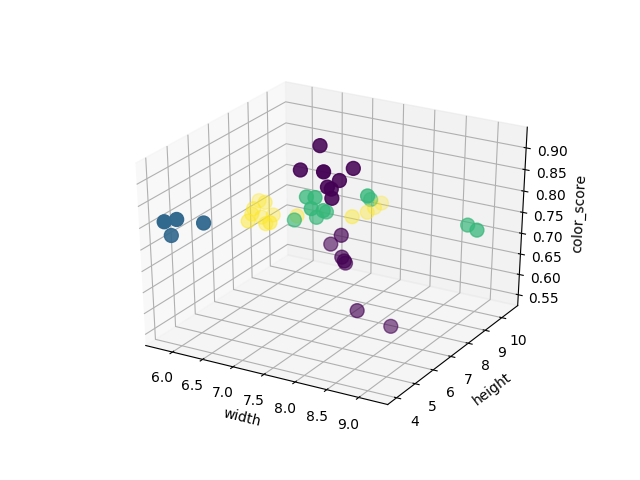

In [44]:
#Tambien podemos hacer un scatter plot en 3D considerando 3 variables contenidas en X_train
# plotting a 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_train['width'], X_train['height'], X_train['color_score'], c = y_train, marker = 'o', s=100)
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.set_zlabel('color_score')
plt.show()

### Entrenar el clasificador

Ahora comenzamos con la etapa de entrenar el clasificador. Para ellos usaremos el algoritmo k-nearest neighbors o k-NN. Este puede ser usado para problemas de clasificación y regresión. Este algotirmo esta basado en lo que se conoce como instance based (basado en instancia) o memory based supervised learnig (aprendizaje supervisado basado en memoria). Esto siginifica que el programa trabaja memorizando las etiquetas del set de entrenamiento para luego usar esas memorias y clasificar nuevos objetos. la k en el algotirmo se refiere al numero de vecinos que el clasificador recuperara y usará para hacer las predicciones. Este algoritno cuenta con 3 pasos:

i) dado una instancia nueva para clasificar, el algoritmo buscara en la memoria entrenadapara encontrar los k ejemplos que se parezcan más a la instancia.

ii) el clasificador mirará las etiquetas de de los k ejemplos 

iii) finalmente combinara las etiquetas de esos ejemplos para hacer la prediccion de la etiqueta del objeto nuevo (por simple mayoria de votos)

Para usar este algoritmo necesitamos especificar 4 cosas:

 i) Una distancia (puntos en un espacio euclideano. Metrica de Minkowsky).
 
 ii) Cuantos vecinos cercanos usar.
 
 iii) Darle peso a algun vecino.
 
 iv) una vez etiquetado el k vecino, debemos especificar como combinarlos para producir la predicción final (votacion por mayoria).

### Create train-test split

In [45]:
# Para este ejemplo solo usaremos masa, ancho altura de cada fruta 
X = fruits[['mass', 'width', 'height']]
y = fruits['fruit_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)
print('{:.2f}% de los datos X son para entrenar y {:.2f}% de X son para test'.format(len(X_train)/len(X), len(X_test)/len(X)))
print('{:.2f}% de los datos y son para entrenar y {:.2f}% de y son para test'.format(len(y_train)/len(y), len(y_test)/len(y)))

0.75% de los datos X son para entrenar y 0.25% de X son para test
0.75% de los datos y son para entrenar y 0.25% de y son para test


### Crear el clasificador

Escogemos el numero de vecinos cerecanos a considerar. Para este caso usamos 5

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)

### Entrenamos el clasificador 

Usamos el dataset train para entrenar el clasificador.

In [47]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### Estimar la precision del clasificador con datos nuevos.

Una vez creado y entrenado el clasificador podemos ver que tan confiable es la predicción de este con datos nuevos, es decir con datos que no usamos para entrenarlo. Para eso usaremos los datos test que separamos del sample original. Usando el metodo score. Este metodo tomara los puntos de test y calculará la fracción de puntos que fueron etiquetados correctamente, sobre todos los puntos de test.

In [48]:
knn.score(X_test, y_test)

0.5333333333333333

### Predecir frutas con el clasificador

Ahora que tenemos el clasificados entrenado podemos intriducirle datos nuevos para ver que predicción hace.

In [62]:
fruit_prediction = knn.predict([[20, 4.3, 5.5]])
lookup_fruit_name[fruit_prediction[0]]

'orange'

In [50]:
fruit_prediction = knn.predict([[100, 6.3, 8.5]])
lookup_fruit_name[fruit_prediction[0]]

'lemon'

###  Graficar los bordes de decisión del clasificador k-NN

Para eso definimos la funcion plot_fruit_knn

In [51]:
import seaborn as sn
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatches
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches

def plot_fruit_knn(X, y, n_neighbors, weights):
    if isinstance(X, (pd.DataFrame,)):
        X_mat = X[['height', 'width']].as_matrix()
        y_mat = y.as_matrix()
    elif isinstance(X, (np.ndarray,)):
        # When X was scaled is already a matrix
        X_mat = X_mat[:, :2]
        y_mat = y.as_matrix()
        print(X_mat)

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#AFAFAF'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                         np.arange(y_min, y_max, mesh_step_size))
    # np.c_ Translates slice objects to concatenation along the second axis
    # e.g. np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
    # ravel() Returns a contiguous flattened array.
    # x = np.array([[1, 2, 3], [4, 5, 6]])
    # np.ravel(x) = [1 2 3 4 5 6]

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    patch0 = mpatches.Patch(color='#FF0000', label='apple')
    patch1 = mpatches.Patch(color='#00FF00', label='mandarin')
    patch2 = mpatches.Patch(color='#0000FF', label='orange')
    patch3 = mpatches.Patch(color='#AFAFAF', label='lemon')
    plt.legend(handles=[patch0, patch1, patch2, patch3])


    plt.xlabel('height (cm)')
    plt.ylabel('width (cm)')

    plt.show()

<IPython.core.display.Javascript object>


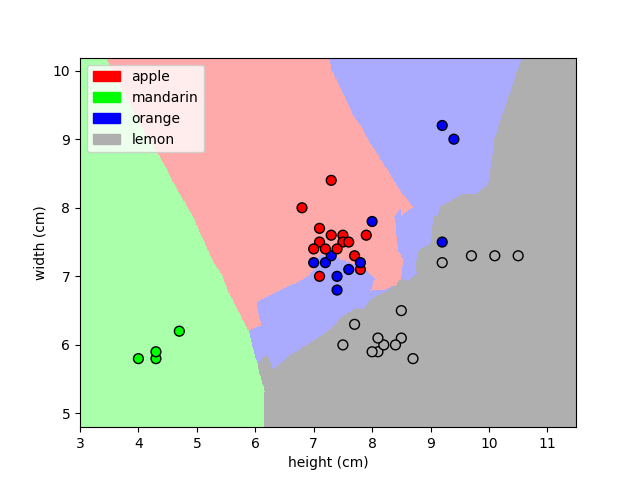

In [52]:
# Escogemos los 5 vecinos cercanos. La opcion uniform hace referencia a que todos los vecinos tienen el mismo peso
plot_fruit_knn(X_train, y_train, 5, 'uniform')   

### Que tan sensible es el clasificador a variaciones en el parametro k

Esto me indica que a medida que aumentamos el valor de k, la eficiencia de la predicción va disminuyendo

<IPython.core.display.Javascript object>


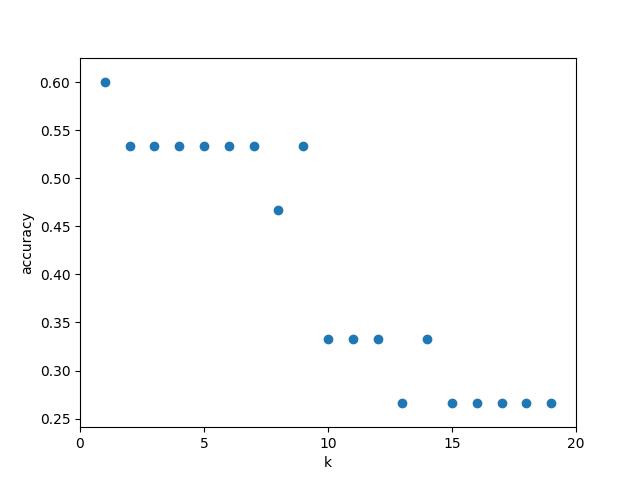

In [53]:
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);

### Que tan sensible es la precisión del clasificador a variaciones en la fracción train/test ?

A medida que aimentamos el porcentaje del dataset de entrenamiento, aumenta la eficiencia del clasificador

<IPython.core.display.Javascript object>


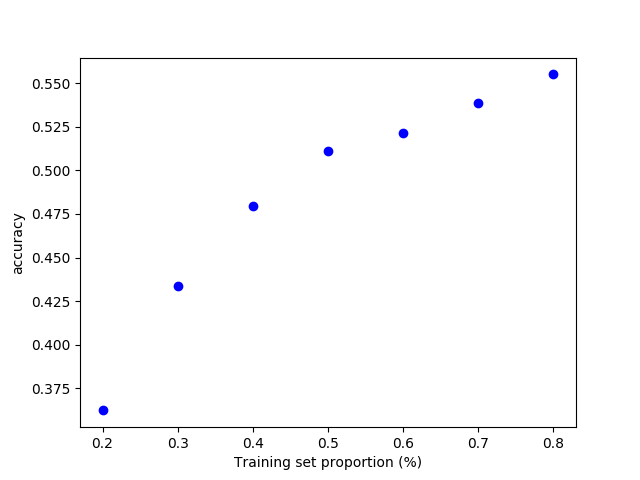

0.8 0.5549716383049716
0.7 0.5385385385385385
0.6 0.5211461461461462
0.5 0.5112445779112446
0.4 0.479590701812924
0.3 0.4334811001477668
0.2 0.36242492492492495


In [59]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 5)

plt.figure()

for s in t:
    scores = []
    for i in range(1,1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-s)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    print(s,np.mean(scores))       
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');

### Algunas conclusiones

a) La elección de un valor bajo para el parametro k (cercano a 1) hace más probable que sobreajuste los datos de entrenamiento, haciendo que la precisión del test sea baja, en comparación con un valor alto de k. Esto es debido a que la predicción puede sufrir de variaciones producto de valores faltantes, ruido, etc. Al escoger valores de k más grandes los límites entre clusters son más suaves y no tan fragmentados, haciendo que hayan menos variaciones producto de ruido y datos faltantes. Para este ejemplo en particulas podemos ver que la precisión del clasificador es mucho mejor cuando k=1, esto es solo para este caso en particular. En general la elección del mejor valor de k puede variar mucho dependiendo del data set por lo que hay que tener cuidado en la eleccióny considerar también la proporción de datos a entrenar vs datos a testear.

b) Seleccionando un valor de k igual al numero de puntos del set para entrenar dará como resultado un clasificador que siempre prediga la clase más grande.